In [1]:
import datetime

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas
from scipy import stats
np.set_printoptions(precision=4, suppress=True)
pandas.set_printoptions(notebook_repr_html=False,
                        precision=4,
                        max_columns=12, column_space=10,
                        max_colwidth=25)
from matplotlib import rcParams
#rcParams['text.usetex'] = False
#rcParams['text.latex.unicode'] = False

We have a snapshot for what would happen if the election is held today (Don't go bet on intratrade based on this model). Historically, polls have narrowed as the election nears.

#### Set up some globals for dates

In [2]:
today = datetime.datetime(2012, 10, 2)
election = datetime.datetime(2012, 11, 6)
days_before = election - today
date2004 = datetime.datetime(2004, 11, 2)
days_before2004 = date2004 - days_before
date2008 = datetime.datetime(2008, 11, 4)
days_before2008 = date2008 - days_before

### TODO: Put a basemap map here

#### Load that data and clean

In [3]:
national_2004 = pandas.read_table("/home/skipper/school/talks/538model/data/2004_poll_data.csv")
national_2004.rename(columns={"Poll" : "Pollster"}, inplace=True);

In [4]:
state_data2004 = pandas.read_csv("/home/skipper/school/talks/538model/data/2004-pres-polls.csv")
state_data2008 = pandas.read_csv("/home/skipper/school/talks/538model/data/2008-pres-polls.csv")


In [5]:
state_data2004

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 0 to 878
Data columns:
State       879  non-null values
Kerry       879  non-null values
Bush        879  non-null values
Date        879  non-null values
Pollster    879  non-null values
dtypes: int64(2), object(3)

In [6]:
state_data2004.rename(columns={"Kerry" : "challenger", 
                               "Bush" : "incumbent"}, 
                      inplace=True);
state_data2004["dem_spread"] = (state_data2004["challenger"] - 
                                      state_data2004["incumbent"])

In [7]:
state_data2004.Date.replace({"Nov 00" : "Nov 01", "Oct 00" : "Oct 01"}, 
                            inplace=True);
state_data2004.Date = (state_data2004.Date + ", 2004").apply(
                                                pandas.datetools.parse)

In [8]:
def median_date(row, year="2008"):
    dt1 = pandas.datetools.parse(row["Start"] + ", " + year)
    dt2 = pandas.datetools.parse(row["End"] + ", " + year)
    dates = pandas.date_range(dt1, dt2)
    median_idx = int(np.median(range(len(dates)))+.5)
    return dates[median_idx]

In [9]:
state_data2008["Date"] = state_data2008.apply(median_date, axis=1)
del state_data2008["Start"]
del state_data2008["End"]

In [10]:
actual = national_2004.head(1)
national_2004 = national_2004.ix[national_2004.index[~national_2004.Pollster.isin(["Final Results", "RCP Average"])]]

In [11]:
def split_median_date(row):
    dt = row["Date"]
    dt1, dt2 = dt.split(" - ")
    dates = pandas.date_range(dt1 + ", 2004", dt2 + ", 2004")
    median_idx = int(np.median(range(len(dates)))+.5)
    return dates[median_idx]

In [12]:
national_2004["Date"] = national_2004.apply(split_median_date, axis=1)

In [13]:
national_2004["dem_spread"] = national_2004["Kerry (D)"] - national_2004["Bush (R)"]

In [14]:
state_data2008

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 0 to 1188
Data columns:
State       1189  non-null values
Obama       1189  non-null values
McCain      1189  non-null values
Pollster    1189  non-null values
Date        1189  non-null values
dtypes: int64(2), object(3)

In [15]:
state_data2008.rename(columns={"Obama" : "challenger", 
                               "McCain" : "incumbent"}, 
                      inplace=True);
state_data2008["dem_spread"] = (state_data2008["challenger"] - 
                                      state_data2008["incumbent"])

#### Clean the Pollster names

In [16]:
import pickle
pollster_map = pickle.load(open(
                 "/home/skipper/school/talks/538model/data/pollster_map.pkl", "rb"))

In [17]:
state_data2004.Pollster.replace(pollster_map, inplace=True);
state_data2008.Pollster.replace(pollster_map, inplace=True);
national_2004.Pollster.replace(pollster_map, inplace=True);

#### Get the Pollster weights

These are old weights obtained from the 538 web site. New weights are not published anywhere to my knowledge.

In [18]:
weights = pandas.read_table("/home/skipper/school/talks/538model/"
                            "data/pollster_weights.csv")

In [19]:
state_data2004 = state_data2004.merge(weights, on="Pollster", how="inner");
state_data2008 = state_data2008.merge(weights, on="Pollster", how="inner");

### What's the Assertion?

In [20]:
def edit_tick_label(tick_val, tick_pos):
    if tick_val  < 0:
        text = str(int(tick_val)).replace("-", "Republican+")
    else:
        text = "Democrat+"+str(int(tick_val))
    return text

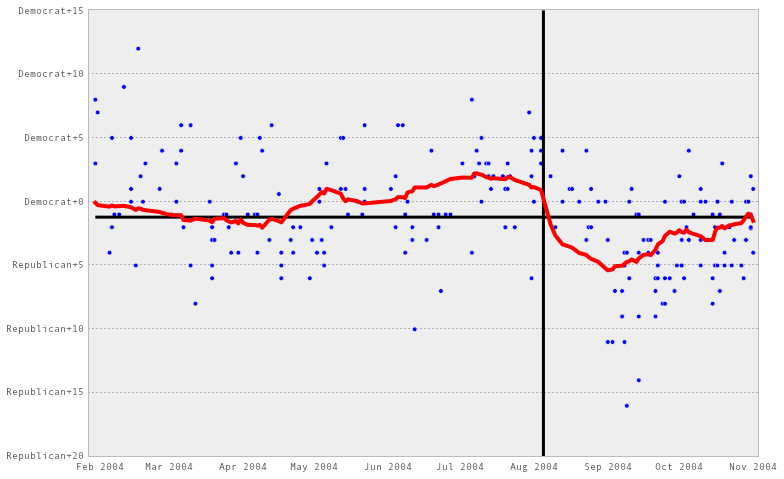

In [21]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

data = national_2004[["Date", "dem_spread"]]
#data = data.ix[data.Date >= days_before2004]
#data = pandas.concat((data, national_data2012[["Date", "dem_spread"]]))
    
data.sort("Date", inplace=True)
dates = pandas.DatetimeIndex(data.Date).asi8

x = data.dem_spread.values.astype(float)
lowess_res = sm.nonparametric.lowess(x, dates, 
                                    frac=.2, it=3)[:,1]

dates_x = lib.ints_to_pydatetime(dates)
axes.scatter(dates_x, data["dem_spread"])
axes.plot(dates_x, lowess_res, color='r', lw=4)
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(-1.21, dates_x[0], dates_x[-1], color='black', lw=3)
axes.vlines(datetime.datetime(2004, 8, 5), -20, 15, lw=3)
axes.margins(0, .00)

### Let's look at the State Polls

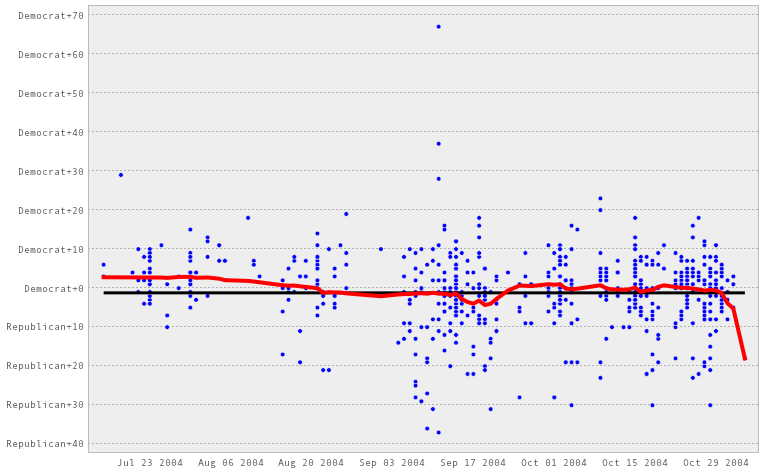

In [22]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

data = state_data2004[["Date", "dem_spread"]]
#data = data.ix[data.Date >= days_before2004]
data = data.ix[data.Date >= datetime.datetime(2004, 7, 15)]
#data = pandas.concat((data, national_data2012[["Date", "dem_spread"]]))
    
data.sort("Date", inplace=True)
dates = pandas.DatetimeIndex(data.Date).asi8

x = data.dem_spread.values.astype(float)
lowess_res = sm.nonparametric.lowess(x, dates, 
                                    frac=.2, it=3)[:,1]

dates_x = lib.ints_to_pydatetime(dates)
axes.scatter(dates_x, data["dem_spread"])
axes.plot(dates_x, lowess_res, color='r', lw=4)
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(-1.21, dates_x[0], dates_x[-1], color='black', lw=3)
axes.margins(0, .05)

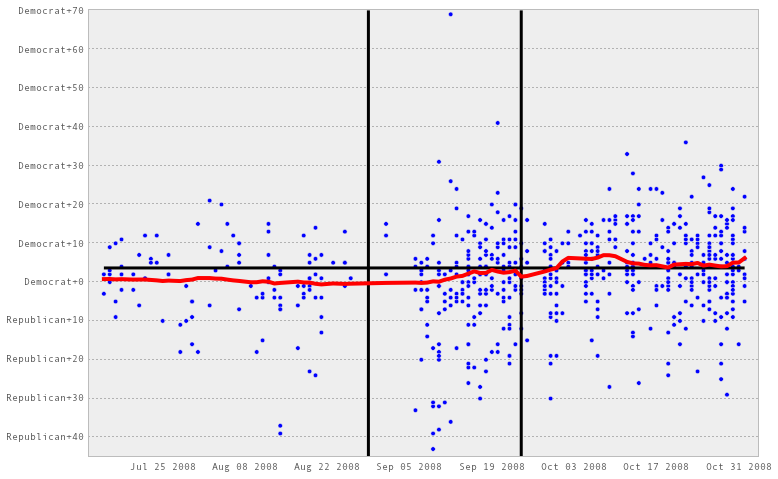

In [23]:
from pandas import lib
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(figsize=(12,8))

data = state_data2008[["Date", "dem_spread"]]
data = data.ix[data.Date >= datetime.datetime(2008, 7, 15)]
#data = data.ix[data.Date >= days_before2008]
#data = pandas.concat((data, national_data2012[["Date", "dem_spread"]]))
    
data.sort("Date", inplace=True)
dates = pandas.DatetimeIndex(data.Date).asi8

x = data.dem_spread.values.astype(float)
lowess_res = sm.nonparametric.lowess(x, dates, 
                                    frac=.2, it=3)[:,1]

dates_x = lib.ints_to_pydatetime(dates)
axes.scatter(dates_x, data["dem_spread"])
axes.plot(dates_x, lowess_res, color='r', lw=4)
axes.yaxis.get_major_locator().set_params(nbins=12)
axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='x')
axes.hlines(3.65, dates_x[0], dates_x[-1], color='black', lw=3)
axes.vlines(datetime.datetime(2008, 8, 29), -45, 70, lw=3)
axes.vlines(datetime.datetime(2008, 9, 24), -45, 70, lw=3)
axes.margins(0, .0)

#### Clean the data

In [24]:
#loadpy https://raw.github.com/gist/3912533/d958b515f602f6e73f7b16d8bc412bc8d1f433d9/state_abbrevs.py;

In [25]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [26]:
state_data2004.State.replace(states_abbrev_dict, inplace=True);
state_data2008.State.replace(states_abbrev_dict, inplace=True);

In [27]:
state_data2004["days_until"] = date2004 - state_data2004.Date
state_data2008["days_until"] = date2008 - state_data2004.Date

In [28]:
#state_data2004 = state_data2004.drop(
#                    state_data2004.index[state_data2004.days_until > days_before])
#state_data2008 = state_data2008.drop(
#                    state_data2008.index[state_data2008.days_until > days_before])

In [29]:
def exp_decay(days):
    # defensive coding, accepts timedeltas
    days = getattr(days, "days", days)
    return .5 ** (days/30.)

In [30]:
state_data2004["time_weight_oct2"] = (days_before2004 - 
                                      state_data2004["Date"]).apply(exp_decay)
state_data2004["time_weight_election"] = (date2004 -
                                      state_data2004["Date"]).apply(exp_decay)
state_data2008["time_weight_oct2"] = (days_before2008 - 
                                      state_data2008["Date"]).apply(exp_decay)
state_data2008["time_weight_election"] = (date2008 -
                                      state_data2008["Date"]).apply(exp_decay)

In [31]:
def weighted_mean(group, weights_name):
    weights = group[weights_name]
    return np.sum(weights*group["dem_spread"]/np.sum(weights))

#### Get weighted average State-level polls for Oct 2 and Election Day

In [32]:
def get_state_averages(dframe, time_weight_name):
    dframe_pollsters = dframe.groupby(["State", "Pollster"])
    dframe_result = dframe_pollsters.apply(weighted_mean, time_weight_name)
    dframe_result.name = "dem_spread"
    dframe_result = dframe_result.reset_index()
    dframe_result = dframe_result.merge(dframe[["Pollster", "Weight"]],
                          on="Pollster")
    return dframe_result.groupby("State").apply(weighted_mean, "Weight")
    

In [33]:
oct2 = state_data2004.Date <= days_before2004
state_polls_oct2_2004 = get_state_averages(state_data2004.ix[oct2], "time_weight_oct2")
state_polls_election_2004 = get_state_averages(state_data2004, "time_weight_election")
updated2004 = state_data2004.ix[~oct2].State.unique()
updated2004.sort()

In [34]:
oct2 = state_data2008.Date <= days_before2008
state_polls_oct2_2008 = get_state_averages(state_data2008.ix[oct2], "time_weight_oct2")
state_polls_election_2008 = get_state_averages(state_data2008, "time_weight_election")
updated2008 = state_data2008.ix[~oct2].State.unique()
updated2008.sort()

#### Get Economic Data

<table>
    <thead>
        <tr style="background: black; color: white; text-align: center">
            <th style="padding: 15px; border-right-color: white; text-align: center">FRED Variable</th>
            <th style="padding: 15px; border-left-color: white; text-align: center">Explanation</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>PAYEMS</b></td>
            <td>Nonfarm-Payrolls (Job Growth)</td>
        </tr>
        <tr>
            <td><b>PI</b></td>
            <td>Personal Income</td>
        </tr>
        <tr>
            <td><b>INDPRO</b></td>
            <td>Industrial Production</td>
        </tr>
        <tr>
            <td><b>PCEC96</b></td>
            <td>Consumption</td>
        </tr>
        <tr>
            <td><b>CPIAUCSL</b></td>
            <td>Inflation</td>
        </tr>
    </tbody>
</table>

In [35]:
from pandas.io.data import DataReader

In [36]:
series = dict(jobs = "PAYEMS",
              income = "PI",
              prod = "INDPRO",
              cons = "PCEC96",
              prices = "CPIAUCSL")

In [37]:
try:
    indicators = []
    for variable in series:
        data = DataReader(series[variable], "fred", start="2000-10-1")
        data.rename(columns={series[variable] : variable}, inplace=True)
        indicators.append(data)
    indicators = pandas.concat(indicators, axis=1)
    indicators.to_csv("/home/skipper/school/talks/538model/tmp_indicators_full.csv")
except: # probably not online
    indicators = pandas.read_csv("/home/skipper/school/talks/538model/tmp_indicators_full.csv", 
                                 parse_dates=True)
    indicators.set_index("DATE", inplace=True)
    # why doesn't it do this automaticall?
    indicators.index = pandas.DatetimeIndex(indicators.index)

For stock variables, just compute annualized quarterly growth rates (end - beginning)/beginning * 400 and average.

In [38]:
quarterly_growth = np.log(indicators.resample("Q", 
                          how="mean")).diff() * 400
annualized = quarterly_growth.resample("A", how="mean")

In [39]:
quarterly_growth = quarterly_growth.dropna()

Try to be rigorous about what the voters know at the time of election.

In [40]:
econ2004 = quarterly_growth.ix[:15].resample('A', 'mean').mean()

In [41]:
econ2008 = quarterly_growth.ix[15:31].resample('A', 'mean').mean()

Leave out last quarter 2008 because that's on Bush? Do voters see it that way...?

In [42]:
econ2012 = quarterly_growth.ix[32:].resample('A', 'mean').mean()

For flow variables, sum the quarters and get annualized quarter over quarter changes then average.

#### Get Demographic Data

Partisan voting index

In [43]:
pvi = pandas.read_csv("/home/skipper/school/talks/538model/data/partisan_voting.csv")
pvi.set_index("State", inplace=True);
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

State
Alabama                -13
Alaska                 -13
Arizona                 -6
Arkansas                -9
California               7
Colorado                 0
Connecticut              7
Delaware                 7
District of Columbia    39
Florida                 -2
Georgia                 -7
Hawaii                  12
Idaho                  -17
Illinois                 8
Indiana                 -6
Iowa                     1
Kansas                 -12
Kentucky               -10
Louisiana              -10
Maine                    5
Maryland                 9
Massachusetts           12
Michigan                 4
Minnesota                2
Mississippi            -10
Missouri                -3
Montana                 -7
Nebraska               -13
Nevada                   1
New Hampshire            2
New Jersey               4
New Mexico               2
New York                10
North Carolina          -4
North Dakota           -10
Ohio                    -1
Oklahoma              

Gallup party affiliation (Poll Jan.-Jun. 2012)

In [44]:
party_affil = pandas.read_csv("/home/skipper/school/talks/538model/"
                              "data/gallup_electorate.csv")
party_affil.Democrat = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil.set_index("State", inplace=True);
party_affil.rename(columns={"Democrat Advantage" : "dem_adv"}, inplace=True);
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican
party_affil[["dem_adv", "no_party"]]

                      dem_adv  no_party
State                                  
District of Columbia    66.30       8.3
Rhode Island            26.00      21.0
Hawaii                  25.60      17.0
New York                21.20      17.2
Maryland                20.20      12.2
Massachusetts           19.10      14.1
Delaware                17.40      16.4
Connecticut             15.40      15.8
Vermont                 13.90      16.3
California              13.70      17.1
Illinois                12.60      15.8
New Jersey              11.50      16.7
Michigan                11.10      15.7
Minnesota               10.20      13.4
Washington               9.80      14.8
Oregon                   8.10      13.7
Pennsylvania             5.20      12.4
Maine                    4.40      16.8
New Mexico               3.60      14.2
Ohio                     3.60      15.4
West Virginia            3.40      12.8
Wisconsin                2.80      12.8
Iowa                     1.80      15.4


Census data

In [45]:
census_data_2012 = pandas.read_csv("/home/skipper/school/talks/"
                              "538model/data/census_demographics.csv")
def capitalize(s):
    s = s.title()
    s = s.replace("Of", "of")
    return s
census_data_2012["State"] = census_data_2012.state.map(capitalize)
del census_data_2012["state"]
census_data_2012.set_index("State", inplace=True);

In [46]:
census_data_2000 = pandas.read_csv("/home/skipper/school/talks/"
                                   "538model/data/census_data_2000.csv")
census_data_2000.set_index("State", inplace=True);

In [47]:
census_data_2005 = (census_data_2000 + census_data_2012) / 2.

#### Model reversion to the "mean"

##### A little more data preparation

In [48]:
changes_2004 = state_polls_election_2004.ix[updated2004].sub(
                    state_polls_oct2_2004)
changes_2004 = changes_2004.dropna()

In [49]:
changes_2008 = state_polls_election_2008.ix[updated2008].sub(
                    state_polls_oct2_2008)
changes_2008 = changes_2008.dropna()

In [50]:
changes_2004

Alabama          -1.533
Arizona          -2.196
Arkansas         -0.278
California       -0.022
Colorado         -0.615
Florida           0.170
Georgia           2.119
Illinois          3.262
Indiana           2.566
Iowa              0.154
Kansas            1.640
Kentucky         -3.251
Maine             3.151
Maryland          2.609
Michigan         -0.471
Minnesota         0.363
Missouri         -1.095
Montana           0.495
Nevada           -1.676
New Hampshire     0.689
New Jersey        3.254
New Mexico       -2.374
New York          2.350
North Carolina   -0.304
Ohio              2.134
Oklahoma         -1.377
Oregon            3.295
Pennsylvania      0.210
Rhode Island     -2.322
South Carolina   -0.051
South Dakota      0.009
Tennessee        -3.368
Texas            -0.620
Virginia         -1.851
Washington       -0.155
West Virginia    -0.254
Wisconsin        -0.022

In [51]:
changes_2008

Alabama           1.409
Alaska            1.032
Arizona           4.619
Arkansas          0.016
California        6.518
Colorado          1.487
Connecticut       1.022
Delaware          4.191
Florida           2.063
Georgia           2.469
Illinois          1.660
Indiana           1.171
Iowa              1.709
Kansas            0.727
Kentucky          1.636
Louisiana        -0.125
Maine             3.708
Massachusetts     4.180
Michigan          1.890
Minnesota         1.464
Mississippi       0.339
Missouri          5.364
Montana           0.403
Nevada            2.548
New Hampshire     6.714
New Jersey        0.812
New Mexico        2.179
New York          5.212
North Carolina    4.124
Ohio              3.271
Oklahoma          1.392
Oregon            5.742
Pennsylvania      3.088
South Carolina    1.726
South Dakota      1.904
Tennessee         1.873
Texas            -0.120
Utah              0.236
Vermont           0.008
Virginia          2.594
Washington        3.398
West Virginia   

In [52]:
for name in econ2004.index:
    census_data_2000[name] = econ2004.ix[name]

In [53]:
for name in econ2008.index:
    census_data_2005[name] = econ2008.ix[name]

In [54]:
census_data_2000["poll_change"] = changes_2004
census_data_2005["poll_change"] = changes_2008
#changes_2008 = changes_2008.join(census_data_2005)

In [55]:
#years = pandas.DataFrame([2004]*len(changes_2004), columns=["Year"], index=changes_2004.index)

In [56]:
#years["poll_change"] = changes_2004
#changes_2004 = years

In [57]:
#years = pandas.DataFrame([2008]*len(changes_2008), columns=["Year"], index=changes_2008.index)
#years["poll_change"] = changes_2008
#changes_2008 = years

In [58]:
#changes_2004

In [59]:
#changes_2004 = changes_2004.join(census_data_2000, how="left")
#changes_2008 = changes_2008.join(census_data_2000, how="left")

In [60]:
census_data_2000["year"] = 2004
census_data_2005["year"] = 2008

In [61]:
changes = pandas.concat((census_data_2000.reset_index(), census_data_2005.reset_index()))

In [62]:
changes.reset_index(drop=True, inplace=True);

In [63]:
changes = changes.dropna() # don't have polls for all the states

In [64]:
predict = census_data_2012.reset_index()

In [65]:
predict["year"] = 2012

Add in Partisan information

In [66]:
changes = changes.merge(pvi.reset_index(), on="State")
predict = predict.merge(pvi.reset_index(), on="State")

Add in Party affiliation information

In [67]:
changes = changes.merge(party_affil[["dem_adv", "no_party"]].reset_index(), on="State")
predict = predict.merge(party_affil[["dem_adv", "no_party"]].reset_index(), on="State")

#### Do the K-means clustering for similar states

In [68]:
from scipy.cluster import vq
from sklearn import cluster

In [69]:
clstr_dta = predict[["per_black", "per_hisp", "per_white", "educ_coll", "pop_density", "per_older", "PVI", "dem_adv"]].values

In [70]:
clstr_dta = vq.whiten(clstr_dta) # might want to play with this to emphasize dimensions?

In [71]:
kmeans = cluster.KMeans(n_clusters=7, n_init=100)
kmeans.fit(clstr_dta)
values = kmeans.cluster_centers_
labels = kmeans.labels_

In [72]:
predict["kmeans_groups"] = labels

In [73]:
for key, grp in predict.groupby("kmeans_groups"): print key, grp.State.tolist()

0 ['Arizona', 'California', 'Nevada', 'New Mexico', 'Texas']
1 ['Iowa', 'Maine', 'Michigan', 'Minnesota', 'New Hampshire', 'Ohio', 'Oregon', 'Pennsylvania', 'Vermont', 'Wisconsin']
2 ['District of Columbia']
3 ['Arkansas', 'Idaho', 'Indiana', 'Kansas', 'Kentucky', 'Missouri', 'Montana', 'Nebraska', 'North Dakota', 'Oklahoma', 'South Dakota', 'Tennessee', 'West Virginia', 'Wyoming']
4 ['Alabama', 'Georgia', 'Louisiana', 'Mississippi', 'North Carolina', 'South Carolina']
5 ['Colorado', 'Connecticut', 'Delaware', 'Florida', 'Hawaii', 'Illinois', 'Maryland', 'Massachusetts', 'New Jersey', 'New York', 'Rhode Island', 'Virginia', 'Washington']
6 ['Alaska', 'Utah']


In [74]:
changes = changes.merge(predict[["kmeans_groups", "State"]], on="State")

Drop D.C. because it's not in the training data.

In [75]:
predict.set_index(["State", "year"], inplace=True);

In [76]:
predict = predict.drop(("District of Columbia", 2012))

#### Let's explore some hypotheses

In [77]:
changes.set_index(["State", "year"], inplace=True);

In [78]:
from statsmodels.formula.api import ols

In [79]:
changes

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 81 entries, ('Alabama', 2004) to ('Wyoming', 2008)
Data columns:
average_income    81  non-null values
cons              81  non-null values
educ_coll         81  non-null values
educ_hs           81  non-null values
income            81  non-null values
jobs              81  non-null values
median_income     81  non-null values
older_pop         81  non-null values
per_black         81  non-null values
per_hisp          81  non-null values
per_older         81  non-null values
per_vote          81  non-null values
per_white         81  non-null values
poll_change       81  non-null values
pop_density       81  non-null values
prices            81  non-null values
prod              81  non-null values
vote_pop          81  non-null values
PVI               81  non-null values
dem_adv           81  non-null values
no_party          81  non-null values
kmeans_groups     81  non-null values
dtypes: float64(21), int64(1)

In [80]:
changes[["dem_adv", "PVI"]].corr()

         dem_adv    PVI
dem_adv    1.000  0.877
PVI        0.877  1.000

In [107]:
formula = ("poll_change ~ C(kmeans_groups) + per_older*per_white + "
           "per_hisp + no_party*np.log(median_income) + PVI")
mod = ols(formula, data=changes).fit()
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:            poll_change   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     5.103
Date:                Sat, 27 Oct 2012   Prob (F-statistic):           3.47e-06
Time:                        12:46:19   Log-Likelihood:                -147.99
No. Observations:                  81   AIC:                             324.0
Df Residuals:                      67   BIC:                             357.5
Df Model:                          13                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept                       -129.4535     67.810     -1.909      0.061      -264.802   

In [82]:
hyp = ", ".join(mod.model.exog_names[:5])

In [83]:
print hyp

Intercept, C(kmeans_groups)[T.1], C(kmeans_groups)[T.3], C(kmeans_groups)[T.4], C(kmeans_groups)[T.5]


In [84]:
print mod.f_test(hyp)

<F test: F=array([[ 1.6831]]), p=[[ 0.1507]], df_denom=67, df_num=5>


In [85]:
predicted2012 = pandas.read_csv("/home/skipper/school/talks/538model/2012-predicted.csv")
predicted2012["year"] = 2012
predicted2012 = predicted2012.set_index(["State", "year"])["poll"]

In [86]:
predicted_change = pandas.Series(mod.predict(predict), index=predict.index)

In [87]:
predicted_change

State           year
Alabama         2012    2.408
Alaska          2012    1.938
Arizona         2012    4.496
Arkansas        2012    1.388
California      2012    7.027
Colorado        2012    3.907
Connecticut     2012    5.086
Delaware        2012    4.265
Florida         2012    3.977
Georgia         2012    4.918
Hawaii          2012    9.279
Idaho           2012    1.652
Illinois        2012    4.905
Indiana         2012    3.014
Iowa            2012    2.634
Kansas          2012    3.370
Kentucky        2012    1.863
Louisiana       2012    3.549
Maine           2012    1.658
Maryland        2012    9.220
Massachusetts   2012    5.800
Michigan        2012    3.936
Minnesota       2012    5.226
Mississippi     2012    3.455
Missouri        2012    2.945
Montana         2012    2.046
Nebraska        2012    2.599
Nevada          2012    4.072
New Hampshire   2012    4.682
New Jersey      2012    5.568
New Mexico      2012    6.087
New York        2012    4.985
North Carolina  201

In [88]:
results = predicted2012 + predicted_change
results

State           year
Alabama         2012       NaN
Alaska          2012       NaN
Arizona         2012    -1.855
Arkansas        2012       NaN
California      2012    26.821
Colorado        2012    10.854
Connecticut     2012    19.053
Delaware        2012       NaN
Florida         2012     6.057
Georgia         2012    -4.050
Hawaii          2012    40.512
Idaho           2012       NaN
Illinois        2012    31.774
Indiana         2012    -3.856
Iowa            2012     4.959
Kansas          2012    -6.171
Kentucky        2012       NaN
Louisiana       2012       NaN
Maine           2012    14.393
Maryland        2012    38.075
Massachusetts   2012    27.616
Michigan        2012    12.497
Minnesota       2012    13.273
Mississippi     2012    -5.182
Missouri        2012     0.970
Montana         2012    -4.989
Nebraska        2012    -6.064
Nevada          2012    13.094
New Hampshire   2012     3.549
New Jersey      2012    19.113
New Mexico      2012    15.232
New York        20

In [89]:
electoral_votes = pandas.read_csv("/home/skipper/school/seaboldgit/talks/pydata/data/electoral_votes.csv")
electoral_votes.sort("State", inplace=True).reset_index(drop=True, inplace=True);
red_states = ["Alabama", "Alaska", "Arkansas", "Idaho", "Kentucky", "Louisiana",
              "Oklahoma", "Wyoming"]
blue_states = ["Delaware"]#, "District of Columbia"]
results.name = "Poll"
results = results.reset_index()
results = results.merge(electoral_votes, on="State", how="left").set_index("State")
results["obama"] = 0
results["romney"] = 0
results.ix[results["Poll"] > 0, ["obama"]] = 1
results.ix[results["Poll"] < 0, ["romney"]] = 1
results.ix[red_states, ["romney"]] = 1
results.ix[blue_states, ["obama"]] = 1

In [90]:
print results["Votes"].mul(results["obama"]).sum() + 3
print results["Votes"].mul(results["romney"]).sum() 

398
140


### CCPR Plots

Component-Component plus residual plots. Partial residual plots attempt to show the relationship between a given independent variable and the response variable given that other independent variables are also in the model.

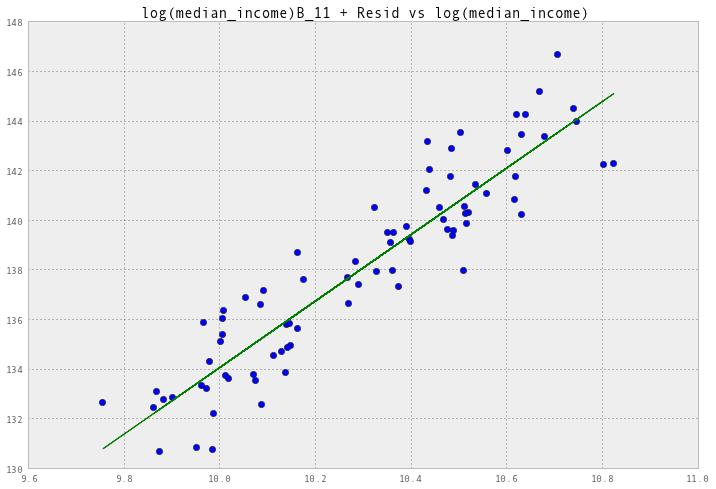

In [91]:
from statsmodels.graphics.regressionplots import plot_ccpr_ax
fig, ax = plt.subplots(figsize=(12,8))
fig = plot_ccpr_ax(mod, 11, ax=ax)
ax = fig.axes[0]
ax.set_title("log(median_income)*B_11 + Resid vs log(median_income)");

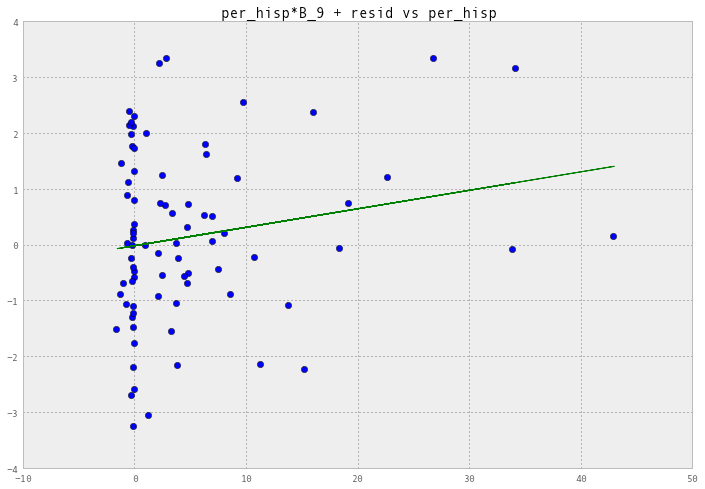

In [106]:
from statsmodels.graphics.regressionplots import plot_ccpr_ax
fig, ax = plt.subplots(figsize=(12,8))
fig = plot_ccpr_ax(mod, 9, ax=ax)
ax = fig.axes[0]
ax.set_title("per_hisp*B_9 + resid vs per_hisp");

In [93]:
X = mod.model.data.orig_exog

In [94]:
X[X.columns[:6]]

                     Intercept  C(kmeans_groups)[T.1]  C(kmeans_groups)[T.3]  C(kmeans_groups)[T.4]  C(kmeans_groups)[T.5]  C(kmeans_groups)[T.6]
State          year                                                                                                                              
Alabama        2004          1                      0                      0                      1                      0                      0
               2008          1                      0                      0                      1                      0                      0
Alaska         2008          1                      0                      0                      0                      0                      1
Arizona        2004          1                      0                      0                      0                      0                      0
               2008          1                      0                      0                      0                      0  

In [95]:
X[X.columns[6:]]

                     per_older  per_white  per_older:per_white  per_hisp  no_party  np.log(median_income)  no_party:np.log(median_income)  PVI
State          year                                                                                                                           
Alabama        2004     13.038     70.289              916.404     1.705      14.4                  9.961                   143.441        -13
               2008      6.589     68.544              451.628     2.853      14.4                 10.362                   149.213        -13
Alaska         2008      2.888     65.649              189.568     4.962      19.8                 10.740                   212.644        -13
Arizona        2004     13.017     63.818              830.698    25.253      12.9                 10.018                   129.233         -6
               2008      6.579     60.609              398.767    27.676      12.9                 10.503                   135.493         -6

In [96]:
false_disc = mod.outlier_test("fdr_bh")
false_disc.sort("unadj_p", inplace=True)

                     student_resid  unadj_p  fdr_bh(p)
State          year                                   
Missouri       2008          2.125    0.037      0.748
New Hampshire  2008          2.099    0.040      0.748
Vermont        2008         -2.080    0.041      0.748
Rhode Island   2004         -2.063    0.043      0.748
Tennessee      2004         -2.032    0.046      0.748
New Jersey     2008         -1.934    0.057      0.774
Arizona        2008          1.861    0.067      0.778
Connecticut    2008         -1.727    0.089      0.784
Kentucky       2004         -1.657    0.102      0.784
Maine          2004          1.553    0.125      0.784
Illinois       2004          1.548    0.126      0.784
California     2008          1.521    0.133      0.784
Minnesota      2008         -1.500    0.138      0.784
Oregon         2008          1.480    0.144      0.784
               2004          1.400    0.166      0.784
Maine          2008          1.392    0.169      0.784
New Jersey

In [97]:
bonf = mod.outlier_test("sidak")
bonf.sort("unadj_p", inplace=True)

                     student_resid  unadj_p  sidak(p)
State          year                                  
Missouri       2008          2.125    0.037     0.954
New Hampshire  2008          2.099    0.040     0.962
Vermont        2008         -2.080    0.041     0.967
Rhode Island   2004         -2.063    0.043     0.972
Tennessee      2004         -2.032    0.046     0.978
New Jersey     2008         -1.934    0.057     0.992
Arizona        2008          1.861    0.067     0.996
Connecticut    2008         -1.727    0.089     0.999
Kentucky       2004         -1.657    0.102     1.000
Maine          2004          1.553    0.125     1.000
Illinois       2004          1.548    0.126     1.000
California     2008          1.521    0.133     1.000
Minnesota      2008         -1.500    0.138     1.000
Oregon         2008          1.480    0.144     1.000
               2004          1.400    0.166     1.000
Maine          2008          1.392    0.169     1.000
New Jersey     2004         

In [98]:
infl = mod.get_influence()
table = infl.summary_frame()

In [99]:
for stat in table.columns:
    print stat

dfb_Intercept
dfb_C(kmeans_groups)[T.1]
dfb_C(kmeans_groups)[T.3]
dfb_C(kmeans_groups)[T.4]
dfb_C(kmeans_groups)[T.5]
dfb_C(kmeans_groups)[T.6]
dfb_per_older
dfb_per_white
dfb_per_older:per_white
dfb_per_hisp
dfb_no_party
dfb_np.log(median_income)
dfb_no_party:np.log(median_income)
dfb_PVI
cooks_d
dffits
dffits_internal
hat_diag
standard_resid
student_resid


Measure the influence of points on prediction

$$\text{DFFITS}=\frac{\hat{y}-\hat{y}_{i}}{s_i\sqrt{h_{ii}} }$$

points greater than

$$2\left\(\frac{p}{\text{nobs}} \right\)^{1/2}$$

might be cause for concern

In [100]:
print 2*np.sqrt(mod.df_model/mod.nobs)

0.80123361677


In [101]:
dffits = np.abs(table['dffits'].copy())
dffits.sort()
dffits[::-1][:15]

State          year
Rhode Island   2004    1.526
Vermont        2008    1.133
New Mexico     2004    1.022
Arizona        2008    0.989
California     2008    0.945
New Jersey     2008    0.909
New Hampshire  2008    0.872
Alaska         2008    0.844
Utah           2008    0.844
Maine          2004    0.810
Connecticut    2008    0.719
Missouri       2008    0.704
Maine          2008    0.611
Tennessee      2004    0.605
New Jersey     2004    0.565
Name: dffits

Indicate influential observations, where you might want more data. 

Overall fit change with deleted observation.

$$\text{Cook's D}=\frac{e_i^2}{p\text{MSE}\frac{h_{ii}}{(1-h_{ii})^2}}$$

In [102]:
print 4/mod.nobs

0.0493827160494


In [103]:
cooks_d = table["cooks_d"].copy()
cooks_d.sort()
print cooks_d[::-1][:15]

State          year
Rhode Island   2004    0.159
Vermont        2008    0.087
New Mexico     2004    0.074
Arizona        2008    0.067
California     2008    0.063
New Jersey     2008    0.057
New Hampshire  2008    0.052
Alaska         2008    0.051
Utah           2008    0.051
Maine          2004    0.046
Connecticut    2008    0.036
Missouri       2008    0.034
Maine          2008    0.026
Tennessee      2004    0.025
New Jersey     2004    0.023
Name: cooks_d


In [104]:
student_resid = np.abs(table.student_resid.copy())
student_resid.sort()
student_resid[::-1][:15]

State          year
Missouri       2008    2.125
New Hampshire  2008    2.099
Vermont        2008    2.080
Rhode Island   2004    2.063
Tennessee      2004    2.032
New Jersey     2008    1.934
Arizona        2008    1.861
Connecticut    2008    1.727
Kentucky       2004    1.657
Maine          2004    1.553
Illinois       2004    1.548
California     2008    1.521
Minnesota      2008    1.500
Oregon         2008    1.480
               2004    1.400
Name: student_resid